### Compare cortical thickness measures across datasets
- NIMHANS
- QPN
- PPMI

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib
from nilearn import datasets, surface, plotting


In [2]:
projects_dir = f"/home/nikhil/projects/neuroinformatics_tools/" 

nimhans_agg_data_dir = f"{projects_dir}/mr_proc-nimhans_serb/analysis/CT/agg_dfs/"
qpn_agg_data_dir = f"{projects_dir}/mr_proc-qpn/analysis/CT/agg_dfs/"

CT_DKT_csv = "CT_DKT_df.csv"
bilateral_vol_csv = "bilateral_vol_ASEG_df.csv"
global_vol_csv = "global_vol_ASEG_df.csv"

# save dirs
figs_dir = "../figs/population_comparisons"

demo_cols = ["participant_id","age","sex","group","hemi","dataset"]

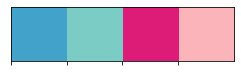

In [3]:
from enum import Enum
class my_colors(Enum):
    QPN_CONTROL = "#7bccc4"
    QPN_PD = "#43a2ca"
    NIM_CONTROL = "#fbb4b9"
    NIM_PD = "#dd1c77"
    
color_list = [my_colors.QPN_PD.value, my_colors.QPN_CONTROL.value,my_colors.NIM_PD.value, my_colors.NIM_CONTROL.value,]
palette = sns.color_palette(palette=color_list) #sns.husl_palette()

sns.palplot(palette)

### Read data

In [4]:
match_age = True
age_thresh = 63

In [5]:
nimhans_CT_DKT_df = pd.read_csv(f"{nimhans_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
nimhans_CT_DKT_df["dataset"] = "NIMHANS"
n_nimhans_participants = len(nimhans_CT_DKT_df["participant_id"].unique())

qpn_CT_DKT_df = pd.read_csv(f"{qpn_agg_data_dir}{CT_DKT_csv}").drop(columns=["Unnamed: 0"])
qpn_CT_DKT_df["dataset"] = "QPN"

n_qpn_participants = len(qpn_CT_DKT_df["participant_id"].unique())
print(f"n_nimhans_participants: {n_nimhans_participants}, n_qpn_participants (all):{n_qpn_participants}")

if match_age:
    print(f"Matching age < {age_thresh}")
    qpn_CT_DKT_df = qpn_CT_DKT_df[qpn_CT_DKT_df["age"]<age_thresh]
    n_qpn_participants = len(qpn_CT_DKT_df["participant_id"].unique())
    print(f"n_nimhans_participants: {n_nimhans_participants}, n_qpn_participants (young):{n_qpn_participants}")

# Concat
CT_DKT_df = pd.concat([nimhans_CT_DKT_df, qpn_CT_DKT_df], axis=0)
CT_DKT_df["ds_group"] = CT_DKT_df["dataset"] + "-" + CT_DKT_df["group"]
print(f"CT_DKT_df shape: {CT_DKT_df.shape}, n_total_participants: {len(CT_DKT_df['participant_id'].unique())}")
CT_DKT_df.head()

n_nimhans_participants: 86, n_qpn_participants (all):201
Matching age < 63
n_nimhans_participants: 86, n_qpn_participants (young):81
CT_DKT_df shape: (334, 38), n_total_participants: 167


,caudalanteriorcingulate,caudalmiddlefrontal,cuneus,entorhinal,fusiform,inferiorparietal,inferiortemporal,insula,isthmuscingulate,lateraloccipital,...,superiortemporal,supramarginal,transversetemporal,participant_id,age,sex,group,hemi,dataset,ds_group
0,2.643,2.648,1.866,3.932,3.098,2.638,2.969,3.294,2.312,2.189,...,3.044,2.717,2.386,SERB088,54.0,M,PD,lh,NIMHANS,NIMHANS-PD
1,3.230,2.844,1.941,3.825,2.900,2.479,3.003,3.427,2.308,2.365,...,2.998,2.589,1.971,SERB058,64.0,M,PD,lh,NIMHANS,NIMHANS-PD
2,2.756,2.717,1.997,3.036,2.709,2.457,2.875,3.183,2.388,2.123,...,2.912,2.526,1.875,SERB049,62.0,M,PD,lh,NIMHANS,NIMHANS-PD
3,2.974,2.603,1.819,3.802,2.701,2.399,2.947,3.205,2.468,2.364,...,2.928,2.532,2.250,SERB084,NaN,NaN,PD,lh,NIMHANS,NIMHANS-PD
4,3.015,2.939,1.998,4.177,3.054,2.831,3.403,3.701,2.462,2.382,...,3.118,2.933,2.776,SERB063,56.0,M,PD,lh,NIMHANS,NIMHANS-PD


### Avg CT difference

In [6]:
CT_diff = nimhans_CT_DKT_df.set_index(demo_cols).mean().values - qpn_CT_DKT_df.set_index(demo_cols).mean().values
CT_diff.mean()

0.26044370120307875

### Subsample QPN to match age

In [7]:
CT_DKT_df.groupby(["dataset","group"])["age"].describe()

count       mean       std   min   25%   50%    75%   max
dataset group                                                             
NIMHANS PD       108.0  55.388889  7.165381  36.0  50.0  56.0  61.00  67.0
        control   30.0  52.000000  5.907330  41.0  48.5  53.0  56.75  60.0
QPN     PD       136.0  55.961765  5.279760  40.9  53.2  57.1  60.05  62.9
        control   26.0  52.515385  7.628247  37.7  49.8  55.4  57.60  62.6

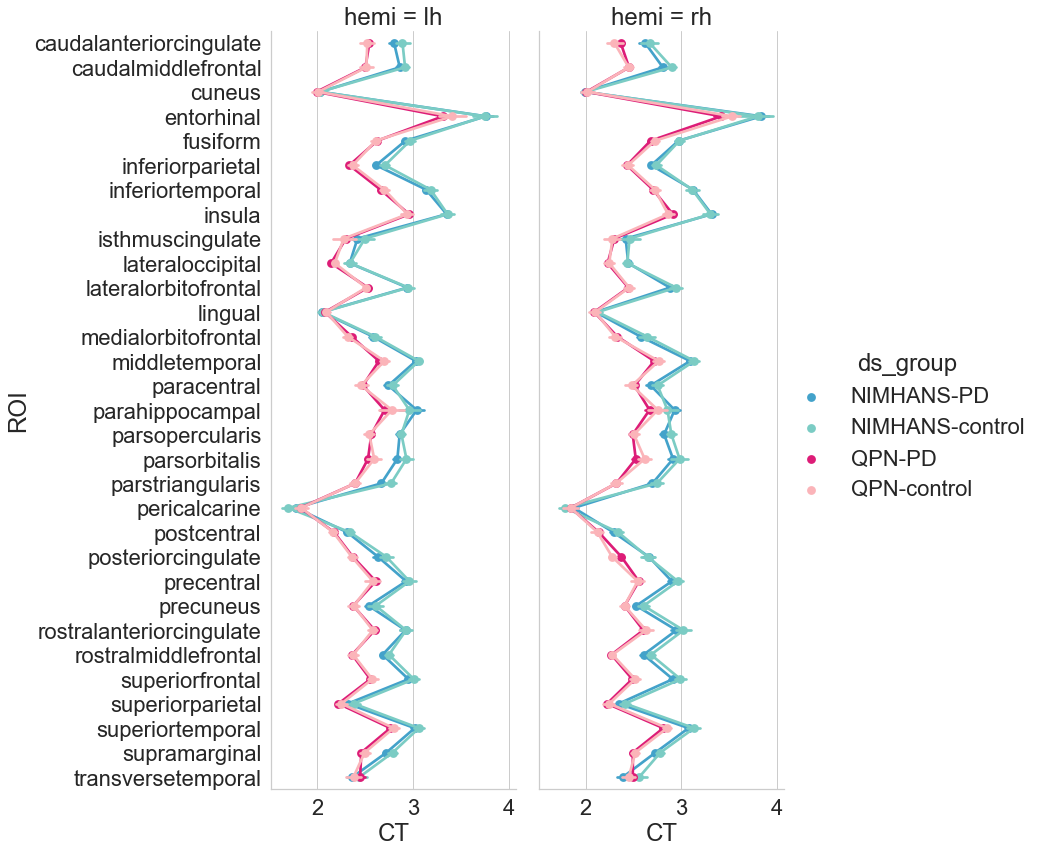

In [8]:
save_fig = False

CT_DKT_df_melt = CT_DKT_df.melt(
    id_vars=demo_cols + ["ds_group"],
    var_name="ROI", 
    value_name="CT")

plot_df = CT_DKT_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="ROI",x="CT", hue="ds_group", col="hemi",kind="point",palette=palette, data=plot_df, aspect=0.5, height=12)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/DKT.png")

### Aseg bilateral volume

In [9]:
nimhans_hemi_ASEG_df = pd.read_csv(f"{nimhans_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_hemi_ASEG_df["dataset"] = "NIMHANS"
n_nimhans_participants = len(nimhans_hemi_ASEG_df["participant_id"].unique())

qpn_hemi_ASEG_df = pd.read_csv(f"{qpn_agg_data_dir}{bilateral_vol_csv}").drop(columns=["Unnamed: 0"])
qpn_hemi_ASEG_df["dataset"] = "QPN"
n_qpn_participants = len(qpn_hemi_ASEG_df["participant_id"].unique())
print(f"n_nimhans_participants: {n_nimhans_participants}, n_qpn_participants:{n_qpn_participants}")

if match_age:
    print(f"Matching age < {age_thresh}")
    qpn_hemi_ASEG_df = qpn_hemi_ASEG_df[qpn_hemi_ASEG_df["age"]<age_thresh]
    n_qpn_participants = len(qpn_hemi_ASEG_df["participant_id"].unique())
    print(f"n_nimhans_participants: {n_nimhans_participants}, n_qpn_participants (young):{n_qpn_participants}")


# Concat
hemi_ASEG_df = pd.concat([nimhans_hemi_ASEG_df, qpn_hemi_ASEG_df], axis=0)
hemi_ASEG_df["ds_group"] = hemi_ASEG_df["dataset"] + "-" + hemi_ASEG_df["group"]
print(f"hemi_ASEG_df shape: {hemi_ASEG_df.shape}")
hemi_ASEG_df.head()

n_nimhans_participants: 86, n_qpn_participants:201
Matching age < 63
n_nimhans_participants: 86, n_qpn_participants (young):81
hemi_ASEG_df shape: (334, 21)


,Lateral-Ventricle,Accumbens-area,Cerebellum-Cortex,vessel,VentralDC,Cerebellum-White-Matter,Amygdala,Caudate,Thalamus-Proper,Inf-Lat-Vent,...,choroid-plexus,Putamen,Hippocampus,participant_id,age,sex,group,hemi,dataset,ds_group
0,9170.500000,394.600006,49608.800781,125.800003,3958.899902,14102.900391,1659.300049,3355.899902,6357.399902,305.000000,...,684.400024,4586.500000,3580.399902,SERB088,54.0,M,PD,lh,NIMHANS,NIMHANS-PD
1,7667.399902,177.800003,42569.199219,24.000000,3381.600098,12641.299805,1223.000000,2633.600098,5716.799805,499.500000,...,623.900024,3512.899902,3400.500000,SERB058,64.0,M,PD,lh,NIMHANS,NIMHANS-PD
2,16945.599609,431.500000,50561.199219,29.299999,3974.399902,20009.800781,1357.099976,3021.699951,6195.899902,773.900024,...,1066.400024,4779.700195,3541.500000,SERB049,62.0,M,PD,lh,NIMHANS,NIMHANS-PD
3,10064.700195,349.500000,41859.898438,13.900000,3525.199951,10348.900391,1344.599976,1672.599976,5412.100098,195.899994,...,818.299988,2910.699951,3827.000000,SERB084,NaN,NaN,PD,lh,NIMHANS,NIMHANS-PD
4,8531.599609,403.799988,46157.500000,40.000000,3328.600098,11251.599609,1442.900024,2352.199951,5824.899902,580.599976,...,592.799988,3410.100098,3377.800049,SERB063,56.0,M,PD,lh,NIMHANS,NIMHANS-PD


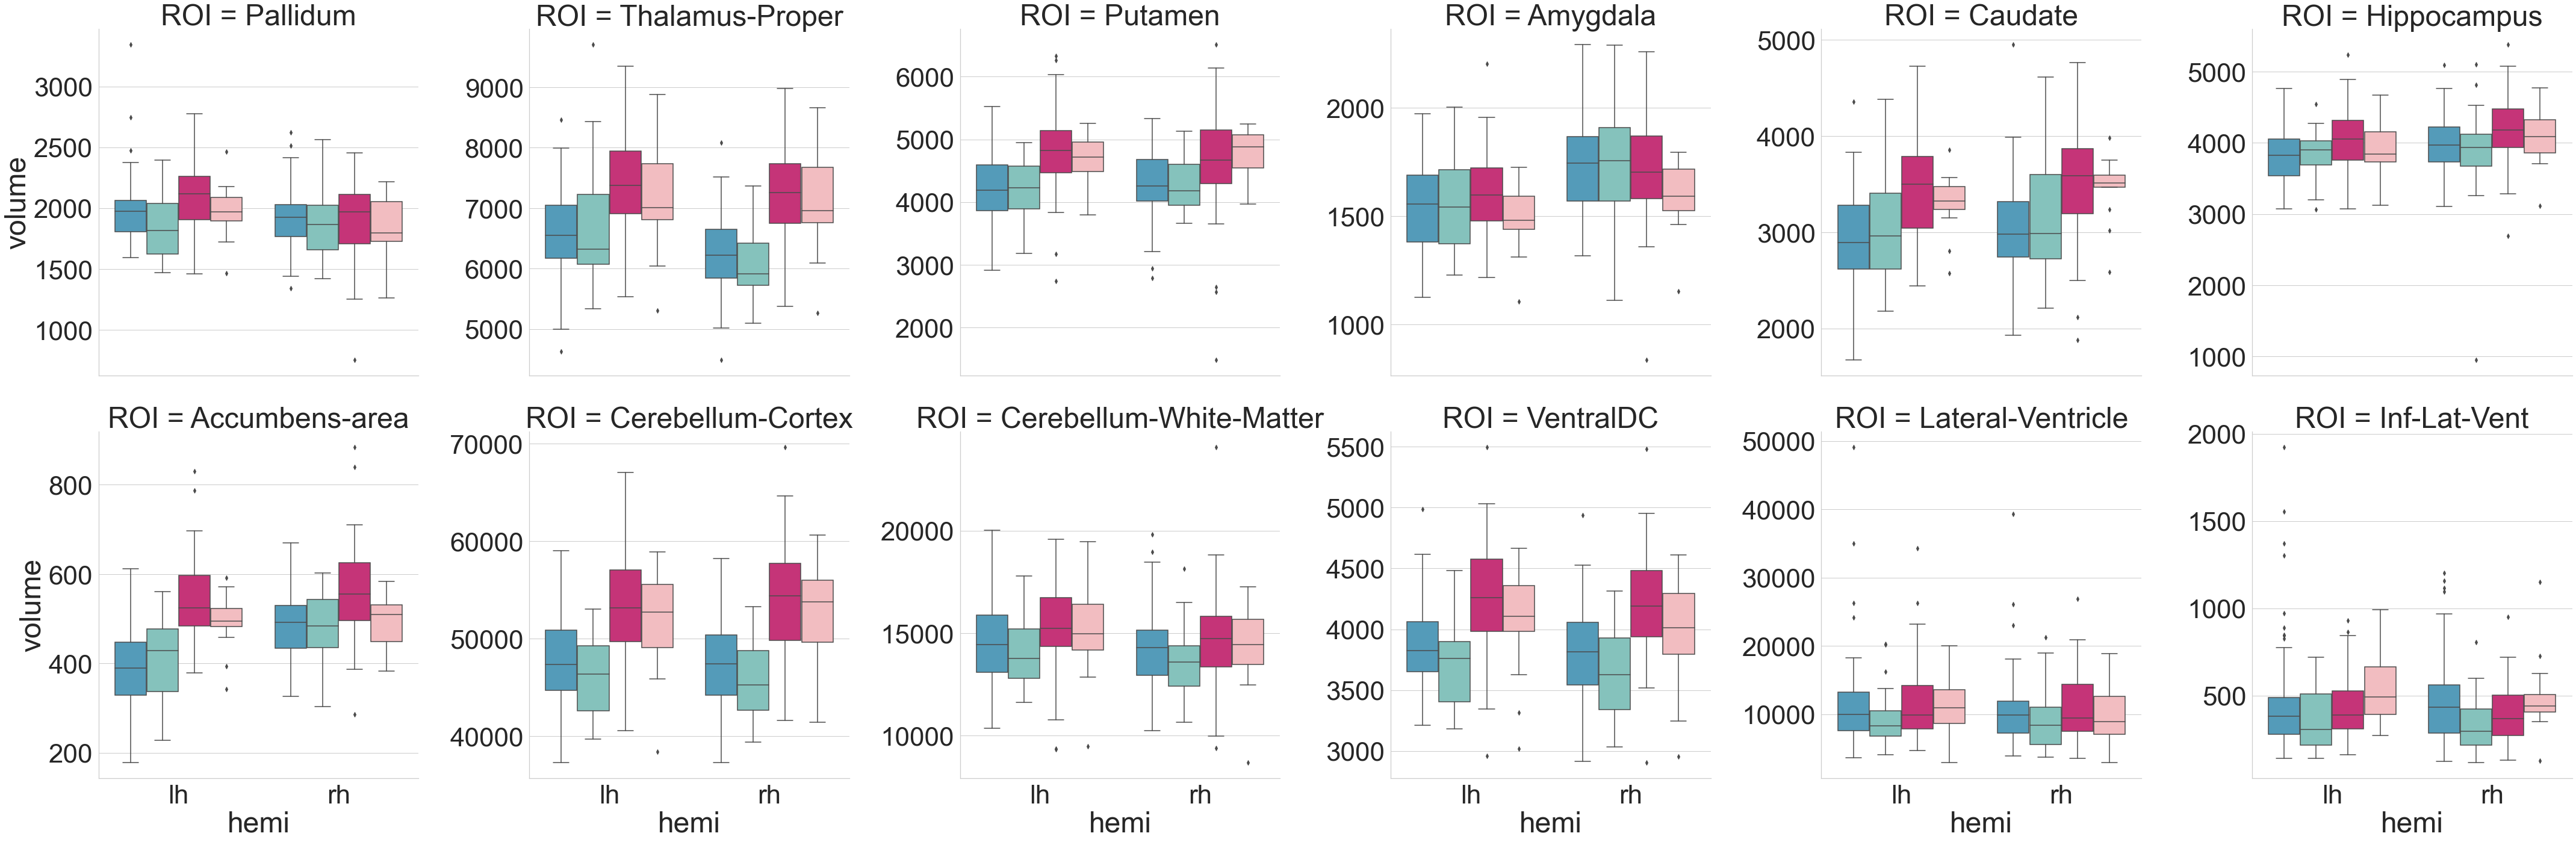

In [15]:
save_fig = False

vol_ASEG_df_melt = hemi_ASEG_df.melt(
    id_vars=demo_cols + ["ds_group"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = vol_ASEG_df_melt.copy()
plot_df["ROI"] = plot_df["ROI"].astype(str)
hemi_roi_list = ['Pallidum', 'Thalamus-Proper', 'Putamen',  'Amygdala', 'Caudate', 'Hippocampus', 'Accumbens-area', 
                'Cerebellum-Cortex','Cerebellum-White-Matter','VentralDC', 'Lateral-Ventricle','Inf-Lat-Vent']

sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="ds_group", col="ROI",kind="box", col_wrap=6, col_order=hemi_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False, legend=False)
    # g.tick_params(axis='x', rotation=90, labelsize=14)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_hemi.png")

### Global volumes

In [11]:
nimhans_global_ASEG_df = pd.read_csv(f"{nimhans_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
nimhans_global_ASEG_df["dataset"] = "NIMHANS"
n_nimhans_participants = len(nimhans_global_ASEG_df["participant_id"].unique())

qpn_global_ASEG_df = pd.read_csv(f"{qpn_agg_data_dir}{global_vol_csv}").drop(columns=["Unnamed: 0"])
qpn_global_ASEG_df["dataset"] = "QPN"
n_qpn_participants = len(qpn_global_ASEG_df["participant_id"].unique())

print(f"n_nimhans_participants: {n_nimhans_participants}, n_qpn_participants:{n_qpn_participants}")

if match_age:
    print(f"Matching age < {age_thresh}")
    qpn_global_ASEG_df = qpn_global_ASEG_df[qpn_global_ASEG_df["age"]<age_thresh]
    n_qpn_participants = len(qpn_global_ASEG_df["participant_id"].unique())
    print(f"n_nimhans_participants: {n_nimhans_participants}, n_qpn_participants (young):{n_qpn_participants}")

# Concat
global_vol_ASEG_df = pd.concat([nimhans_global_ASEG_df, qpn_global_ASEG_df], axis=0)
global_vol_ASEG_df["ds_group"] = global_vol_ASEG_df["dataset"] + "-" + global_vol_ASEG_df["group"]
print(f"global_vol_ASEG_df shape: {global_vol_ASEG_df.shape}")
qpn_global_ASEG_df.head()

n_nimhans_participants: 86, n_qpn_participants:201
Matching age < 63
n_nimhans_participants: 86, n_qpn_participants (young):81
global_vol_ASEG_df shape: (167, 23)


,BrainSegNotVentSurf,non-WM-hypointensities,CSF,3rd-Ventricle,EstimatedTotalIntraCranial,4th-Ventricle,BrainSeg,BrainSegNotVent,SubCortGray,Brain-Stem,...,SupraTentorialNotVent,WM-hypointensities,5th-Ventricle,Optic-Chiasm,participant_id,age,sex,group,hemi,dataset
1,1.423165e+06,0.0,1486.500000,1887.400024,1.932300e+06,2606.399902,1457215.0,1423757.0,70481.0,26626.500000,...,1.253226e+06,1731.000000,0.0,212.199997,PD00215,48.5,M,PD,global,QPN
3,1.076999e+06,2.5,1418.699951,1175.000000,1.492908e+06,1684.199951,1114040.0,1077374.0,56202.0,21090.699219,...,9.700843e+05,3868.699951,0.0,121.800003,PD01398,61.9,F,PD,global,QPN
4,8.435806e+05,0.0,871.799988,1069.199951,1.146054e+06,1408.300049,861734.0,843682.0,44332.0,15741.799805,...,7.411936e+05,1220.400024,0.0,114.099998,PD00849,62.2,F,PD,global,QPN
5,1.016271e+06,0.0,1112.900024,1431.000000,1.434878e+06,1837.300049,1040177.0,1016472.0,53094.0,20252.800781,...,8.822462e+05,713.799988,0.0,133.500000,PD01746,55.4,F,control,global,QPN
9,1.187711e+06,0.0,990.000000,1142.800049,1.623276e+06,1678.199951,1208224.0,1187530.0,60897.0,21935.000000,...,1.057140e+06,787.700012,0.0,128.699997,PD01710,50.6,M,PD,global,QPN


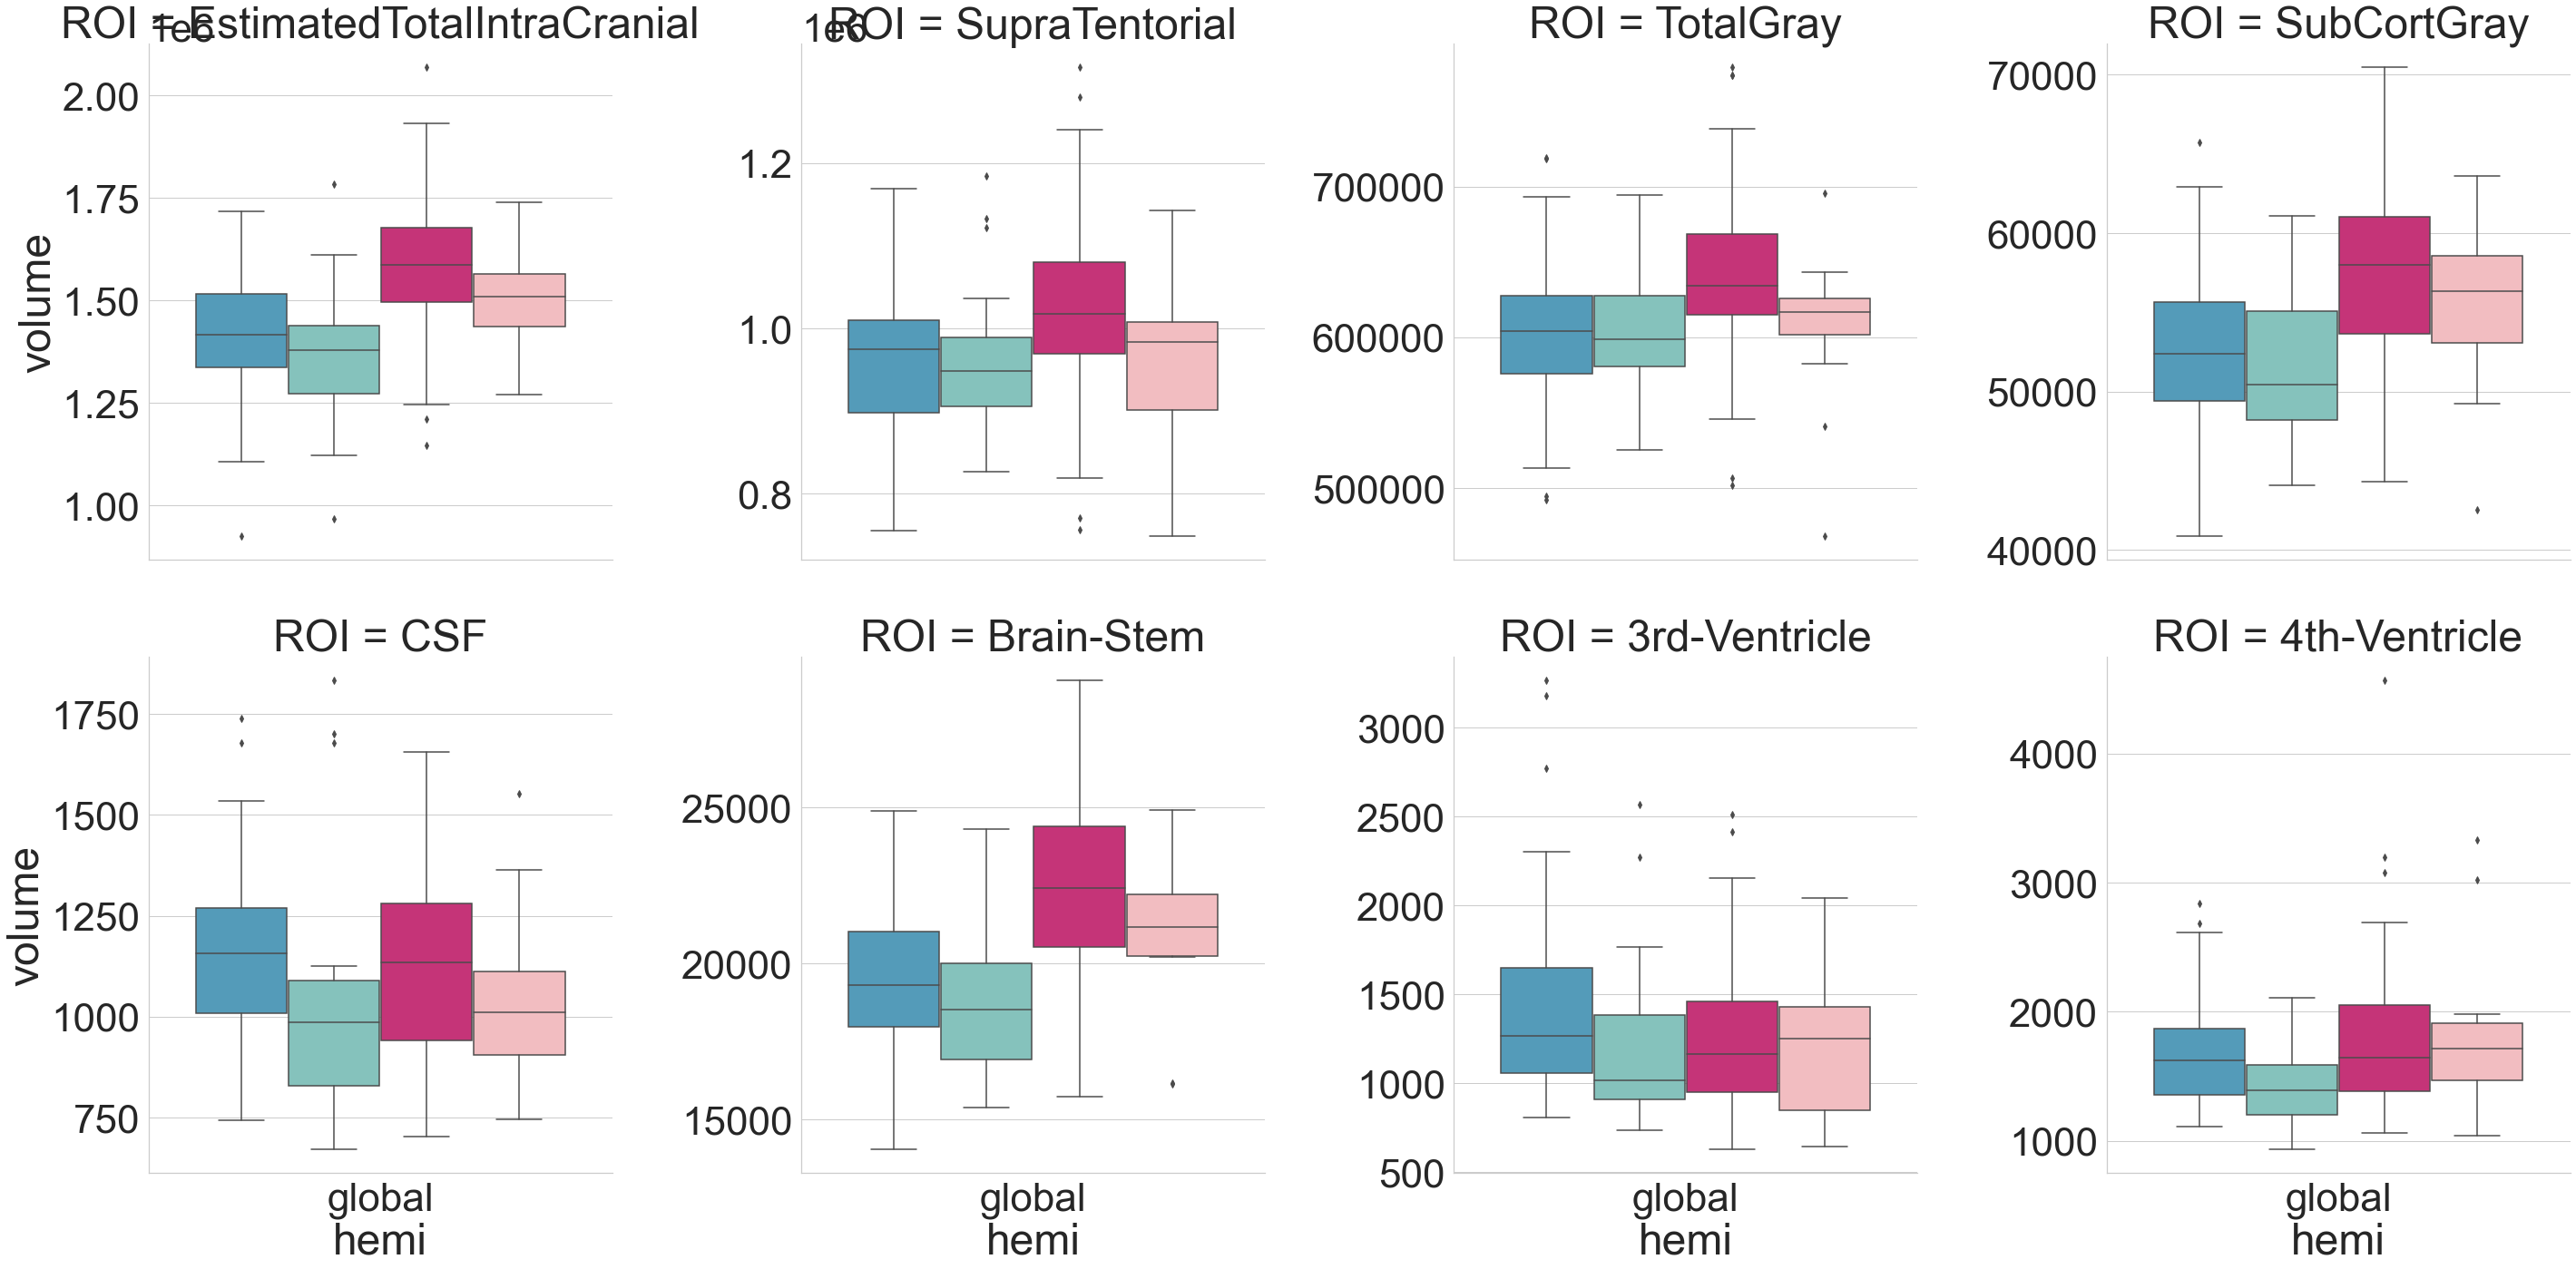

In [16]:
save_fig = False

global_vol_ASEG_df_melt = global_vol_ASEG_df.melt(
    id_vars=demo_cols + ["ds_group"],
    var_name="ROI", 
    value_name="volume",
)

plot_df = global_vol_ASEG_df_melt.copy()

global_roi_list = ["EstimatedTotalIntraCranial", "SupraTentorial", "TotalGray", "SubCortGray", 
                    "CSF","Brain-Stem","3rd-Ventricle","4th-Ventricle"]
plot_df = plot_df[plot_df["ROI"].isin(global_roi_list)]

sns.set(font_scale=4)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="volume",x="hemi", hue="ds_group", col="ROI",kind="box", col_wrap=4, col_order=global_roi_list,
    palette=palette, data=plot_df, aspect=1, height=10, sharey=False, legend=False)

if save_fig:
    g.savefig(f"{figs_dir}/ASEG_global.png")

### Demographics

In [17]:
demo_df = global_vol_ASEG_df[demo_cols].copy()
demo_df.groupby(["dataset","group"]).count()

participant_id  age  sex  hemi
dataset group                                  
NIMHANS PD                   64   54   55    64
        control              22   15   15    22
QPN     PD                   68   68   68    68
        control              13   13   13    13

In [18]:
demo_df.groupby(["dataset","group"])["age"].describe()

count       mean       std   min    25%   50%    75%   max
dataset group                                                              
NIMHANS PD        54.0  55.388889  7.199100  36.0  50.25  56.0  61.00  67.0
        control   15.0  52.000000  6.011893  41.0  49.00  53.0  56.50  60.0
QPN     PD        68.0  55.961765  5.299423  40.9  53.20  57.1  60.05  62.9
        control   13.0  52.515385  7.785547  37.7  49.80  55.4  57.60  62.6